**Cole Turner and Ethan Seal**

Fall 2019

CS343: Neural Networks

Project 4: Transfer Learning

In [104]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)
rgen = np.random.RandomState(1)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


*Sanity check that Tensorflow is installed correctly:*

Executing the following cell should return 3 

In [2]:
tf.print(tf.reduce_sum([tf.Variable(1), tf.Variable(2)]))

3


## Task 1) Implement ConvNet4 in Tensorflow, train/test on STL-10

### 1a) Use the high level `Keras::Sequential` API in Tensorflow 2.0 to implement the architecture of ConvNet4 from the last project. Train and test your network on the STL-10 dataset. 

Recall the `Keras::Sequential` common worflow:

- Build structure of network with `keras::Sequential`.
- Compile network with your choice of optimizer, loss, and metrics.
- Fit the model (remembering to pass in the appropriate training and validation sets). This results a history object that can be used to examine training/validation accuracy and loss.
- Evaluate the model on the test set. This returns test loss and accuracy.

**Notes**:
- You should use the usual STL-10 data acquistion and preprocessing code from your last project.
- You don't need to do a hyperparameter search. Values that worked on the CNN project should get you in the ballpark here. The goal is to show that you know how to put together a `keras::Sequential` model and have it work successfully.
- Tensorflow needs the RGB color channel AFTER the spatial dimensions. For example: (64, 64, 3), not (3, 64, 64). You may therefore need to slightly modify the preprocesssing pipeline for this project.

These documentation pages should be helpful:
- https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary

In [3]:
import load_stl10_dataset
from preprocess_data import preprocess_stl, create_splits

In [93]:

stl_imgs, stl_labels = load_stl10_dataset.load()

Found cached numpy arrays the images and labels. Loading them...
Images are: (5000, 32, 32, 3)
Labels are: (5000,)


In [5]:
classes = np.loadtxt(os.path.join('data', 'stl10_binary', 'class_names.txt'), dtype=str)

In [6]:
# Preprocess image pixel values for the MLP net
stl_imgs, stl_labels = preprocess_stl(stl_imgs, stl_labels)
print(f'stl_imgs dtype is {stl_imgs.dtype} and it should be float64')
print(f'stl_imgs max is {np.max(stl_imgs[:, 1:]):.3f} and it should be 0.668')
print(f'stl_imgs shape is {stl_imgs.shape} and it should be (5000, 32, 32, 3)')
print(f'stl_labels span {stl_labels.min()}->{stl_labels.max()} and it should be 0->9')

imgs.shape (5000, 32, 32, 3)
stl_imgs dtype is float64 and it should be float64
stl_imgs max is 0.668 and it should be 0.668
stl_imgs shape is (5000, 32, 32, 3) and it should be (5000, 32, 32, 3)
stl_labels span 0->9 and it should be 0->9


In [7]:
x_train, y_train, x_test, y_test, x_val, y_val, x_dev, y_dev = create_splits(stl_imgs, stl_labels)  
print ('Train data shape: ', x_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Test data shape: ', x_test.shape)
print ('Test labels shape: ', y_test.shape)
print ('Validation data shape: ', x_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('dev data shape: ', x_dev.shape)
print ('dev labels shape: ', y_dev.shape)

data.shape (5000, 32, 32, 3)
Train data shape:  (3500, 32, 32, 3)
Train labels shape:  (3500,)
Test data shape:  (500, 32, 32, 3)
Test labels shape:  (500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
dev data shape:  (500, 32, 32, 3)
dev labels shape:  (500,)


### 1b) Make 2 "high quality" plots showing the following

- Plot the training and validation accuracy (y axis) over training epochs (x axis).
- Plot the training and validation loss (y axis) over epochs (x axis).

A high quality plot consists of:
- A useful title
- X and Y axis labels
- A legend

In [21]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(input_shape=stl_imgs.shape[1:],filters=32, kernel_size=(7,7),padding="same", activation='relu',),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid', data_format="channels_last" ),
    tf.keras.layers.Flatten(input_shape=(16,16,32)),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=10, activation="softmax") 
]) 
model.summary()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy']) 
hist = model.fit(x_train, y_train, batch_size=4, epochs=20, validation_data=(x_val, y_val), verbose=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4736      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               819300    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 825,046
Trainable params: 825,046
Non-trainable params: 0
_________________________________________________________________
Train on 3500 samples, validate on 500 samples
Epoch 1/20
3500/3500 - 18s - loss: 1.8040 - accuracy: 0.3240 - val_

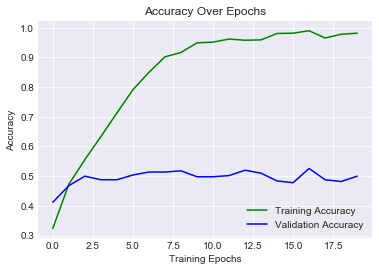

In [22]:
plt.plot(hist.history["accuracy"], label="Training Accuracy", color="green")
plt.plot(hist.history["val_accuracy"], label="Validation Accuracy", color="blue")
plt.title("Accuracy Over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


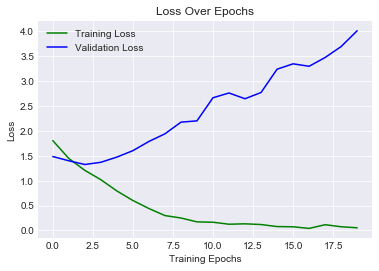

In [23]:
plt.plot(hist.history["loss"], label="Training Loss", color="green")
plt.plot(hist.history["val_loss"], label="Validation Loss", color="blue")
plt.title("Loss Over Epochs")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [24]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Accuracy: {acc}, Loss: {loss}')

500/1 - 1s - loss: 4.6282 - accuracy: 0.4940
Accuracy: 0.49399998784065247, Loss: 4.0347803039550785


**Question 1:** What accuracy do you get on the STL-10 test set? Briefly summarize the hyperparameters that you used to obtain this result.

**Answer 1**

We used 20 epochs, a batch size of 4, a the default learning rate of .001. We get an accuracy of up to 53% but closer to 49% generally in validation. Our test accuracy puts us at 49.4%. We have an epsilon of 1e-07, beta_1=0.9,
and beta_2=0.999. These are standard Adam values. 



**Question 2:** How do the loss and accurary results compare to the CNN project?

**Answer 2**
The loss is similar and the accuracy is a bit higher in this project. It might be because the layers are slightly different or the default hyper parameters are a bit different, but we get slightly higher accuracy here. However, the difference is not drastic. The loss both heads to 0, though the loss falls faster here than it does on the other model we built in the CNN project. We see about a 3% increase from our best models.

## Task 2) Transfer learning

Use Tensorflow 2.0 to download the pre-trained MobileNetV2 network (you may also use InceptionV3, but MobileNetV2 likely will run noticeably faster on your machine). We will use transfer learning to accelerate training to solve a novel problem: **the binary classification task of discriminating whether an image is of a hotdog or not.**

### Overview of the task

- Run some hotdog-or-not dataset images through the network. How does the net seem to classify things correctly?
- Remove the output layer.
- Add a new Dense output layer.
- Freeze (disable) training on all non-output layers.
- Train the last layer on a food dataset. Assess performance. Plot some example images and their classification below

**TODO:**
- Get the **food dataset** on filer: `Courses/CS343/Course_Materials/hot-dog-not-hot-dog`. Copy it into a `data` subfolder in your project directory.
- Run the below code to load in the hot-dog-or-not dataset. Check the shapes to ensure everything is loaded in correctly. 

### 2a) Load in hotdot image dataset

In [11]:
ds_base_dir = 'data/hot-dog-not-hot-dog/numpy/'
hotdog_train_x = np.load(os.path.join(ds_base_dir, 'train_x.npy'))
hotdog_train_y = np.load(os.path.join(ds_base_dir, 'train_y.npy'))
hotdog_test_x = np.load(os.path.join(ds_base_dir, 'test_x.npy'))
hotdog_test_y = np.load(os.path.join(ds_base_dir, 'test_y.npy'))

print(f'Training hotdog split shape: {hotdog_train_x.shape}. Should be (16000, 96, 96, 3)')
print(f'Test hotdog split shape: {hotdog_test_x.shape}. Should be (4000, 96, 96, 3)')

Training hotdog split shape: (16000, 96, 96, 3). Should be (16000, 96, 96, 3)
Test hotdog split shape: (4000, 96, 96, 3). Should be (4000, 96, 96, 3)


### 2b) Preprocess hotdog dataset

In [12]:
hotdog_train_x = 2*(hotdog_train_x - 0.5)
hotdog_test_x = 2*(hotdog_test_x - 0.5)

### 2c) Create hotdog validation set

In [13]:
VAL_PROP = 0.2  # proportion of trainng set to reserve for validation
VAL_SZ = int(VAL_PROP*len(hotdog_train_x))
hotdog_val_x = hotdog_train_x[-VAL_SZ:]
hotdog_val_y = hotdog_train_y[-VAL_SZ:]
hotdog_train_x = hotdog_train_x[:len(hotdog_train_x)-VAL_SZ]
hotdog_train_y = hotdog_train_y[:len(hotdog_train_y)-VAL_SZ]

print(f'Validation hotdog split shape: {hotdog_train_x.shape}. Should be (12800, 96, 96, 3)')

Validation hotdog split shape: (12800, 96, 96, 3). Should be (12800, 96, 96, 3)


### 2d) Load in pre-trained MobileNetV2 network.

**TODO:**
- Load in pre-trained MobileNetV2 network (look up constructor in `tf.keras.applications` or look at the tutorial from class) and set it to a variable called `model`. https://www.tensorflow.org/api_docs/python/tf/keras/applications
- Set the `trainable` field of the model object to be `False` (use dot notation).
- If you call the `summary()` method on the network object, you should see a table with many rows. The top and bottom rows should be:


    input_3 (InputLayer)            [(None, 96, 96, 3)]  0                                           
    __________________________________________________________________________________________________
    out_relu (ReLU)                 (None, 3, 3, 1280)   0           Conv_1_bn[0][0]  

and you should see the following at the bottom:

    Total params: 2,257,984
    Trainable params: 0
    Non-trainable params: 2,257,984

In [14]:
model = tf.keras.applications.MobileNetV2(input_shape=(96,96,3),include_top=False,
                                               weights='imagenet')
model.trainable=False
model.summary()



Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

### 2e) Replace output layer

**TODO:**
- Create a Dense layer object with the correct number of units to deal with the hot-dog or not problem, which will be the new output layer. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
- Create a new `keras/Sequential` model object composed of a Python list of the following:
    - the original model object
    - "Flatten layer"
    - the dense output layer
- Compile the augmented model with the Adam optimizer (learning rate of 0.0001), binary_crossentropy loss, and accuracy metric. https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam https://www.tensorflow.org/api_docs/python/tf/losses

A summary on the augmented model should yield:

    Layer (type)                 Output Shape              Param #   
    =================================================================
    mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
    _________________________________________________________________
    flatten_4 (Flatten)          (None, 11520)             0         
    _________________________________________________________________
    dense_4 (Dense)              (None, 1)                 11521     
    =================================================================
    Total params: 2,269,505
    Trainable params: 11,521
    Non-trainable params: 2,257,984

**Question 3:** What is the accuracy and loss for the network with the untrained output layer?

**Answer:** Our accuracy is 50.2% and our loss is 7.64. It may have been re-run but around 50% makes sense because it is randomly guessing.

**Question 4:** Briefly defend your choice of number of units in the output layer.

**Answer:** Two different classes exist, hot dog or not hot dog. If we only have one output, that it is a hot dog, then everything else will be 0 if it is not a hot dog. Thus, we only need one output node.

In [15]:
mn_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
mn_model.summary()
mn_model.compile(optimizer='adam', learning_rate=.0001,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

loss, acc = mn_model.evaluate(hotdog_test_x, hotdog_test_y, verbose=2)
print(f'Accuracy: {acc}, Loss: {loss}')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11521     
Total params: 2,269,505
Trainable params: 11,521
Non-trainable params: 2,257,984
_________________________________________________________________
4000/1 - 41s - loss: 1.0322 - accuracy: 0.4803
Accuracy: 0.4802500009536743, Loss: 1.0659682302474975


### 2f) Fit the augmented model on the hotdog training data

**Notes**
- Remember to also pass in the hotdog validation data. Train for 10 epochs with a batch size of 32.
- Setting the verbose optional parameter to 2 will give you helpful printouts of performance on the validation set as it completes every epoch of training.


**NOTE:**
- If training time is taking much more 2.5 minutes per epoch on your computer, you could try reducing the number of data samples in train and validation. For example, by default train `N = 12800`. Try `N = 6400` instead. You could do the same for the validation set.

In [16]:
hist = mn_model.fit(hotdog_train_x, hotdog_train_y, 
                    validation_data=(hotdog_val_x,hotdog_val_y),
                     epochs=10,
                     verbose=2,
                     batch_size=32)

Train on 12800 samples, validate on 3200 samples
Epoch 1/10
12800/12800 - 563s - loss: 0.5160 - accuracy: 0.7849 - val_loss: 0.6345 - val_accuracy: 0.7841
Epoch 2/10
12800/12800 - 494s - loss: 0.3766 - accuracy: 0.8490 - val_loss: 1.2810 - val_accuracy: 0.6931
Epoch 3/10
12800/12800 - 570s - loss: 0.3383 - accuracy: 0.8681 - val_loss: 0.5551 - val_accuracy: 0.8169
Epoch 4/10
12800/12800 - 533s - loss: 0.3052 - accuracy: 0.8809 - val_loss: 0.6893 - val_accuracy: 0.7956
Epoch 5/10
12800/12800 - 492s - loss: 0.3085 - accuracy: 0.8827 - val_loss: 0.9803 - val_accuracy: 0.7572
Epoch 6/10
12800/12800 - 477s - loss: 0.2788 - accuracy: 0.8943 - val_loss: 0.6616 - val_accuracy: 0.8194
Epoch 7/10
12800/12800 - 443s - loss: 0.2805 - accuracy: 0.8942 - val_loss: 0.7367 - val_accuracy: 0.8031
Epoch 8/10
12800/12800 - 495s - loss: 0.2822 - accuracy: 0.8977 - val_loss: 0.6866 - val_accuracy: 0.8163
Epoch 9/10
12800/12800 - 455s - loss: 0.3082 - accuracy: 0.8938 - val_loss: 0.7898 - val_accuracy: 0.80

### 2g) Plot hotdog results

Produce 2 high quality plots showing the following:

- Training and validation loss over epoch.
- Training and validation accuracy over epoch.

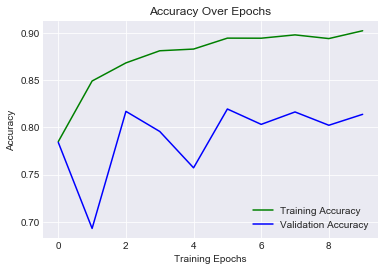

In [17]:
plt.plot(hist.history["accuracy"], label="Training Accuracy", color="green")
plt.plot(hist.history["val_accuracy"], label="Validation Accuracy", color="blue")
plt.title("Accuracy Over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

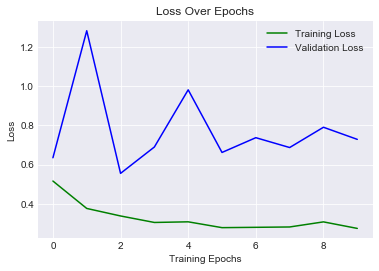

In [18]:
plt.plot(hist.history["loss"], label="Training Loss", color="green")
plt.plot(hist.history["val_loss"], label="Validation Loss", color="blue")
plt.title("Loss Over Epochs")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [19]:
loss, acc = mn_model.evaluate(hotdog_test_x, hotdog_test_y, verbose=2)
print(f'Accuracy: {acc}, Loss: {loss}')

4000/1 - 47s - loss: 0.5166 - accuracy: 0.8095
Accuracy: 0.809499979019165, Loss: 0.7606305013895035


**Question 5:** What accuracy do you achieve on the test set? Briefly summarize the hyperparameters that were used in your model.

**Answer:** We achieve about 80.95% accuracy with a learning rate of .0001. We had a batch size of 32 and only ran for 10 epochs. We used the standard Adam optimizer values. 








**--------------------------------------------------EXTENSION 1----------------------------------------------------**

It is our goal in this extension to expand upon Conv4 to see what sort of accuracies we can achieve. All work is done with the STL10 dataset, though models 10 and 11 use a larger image variation on it.

In [59]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(input_shape=stl_imgs.shape[1:],filters=32, kernel_size=(7,7),padding="same", activation='relu',),
    tf.keras.layers.Conv2D(input_shape=stl_imgs.shape[1:],filters=32, kernel_size=(5,5),padding="same", activation='relu',),
    tf.keras.layers.Conv2D(input_shape=stl_imgs.shape[1:],filters=64, kernel_size=(3,3),padding="same", activation='relu',),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid', data_format="channels_last" ),
    tf.keras.layers.Flatten(input_shape=(16,16,64)),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=10, activation="softmax") 
]) 
model.summary()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy']) 
hist = model.fit(x_train, y_train, batch_size=4, epochs=20, validation_data=(x_val, y_val), verbose=2)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        4736      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               1638500   
_________________________________________________________________
dense_22 (Dense)             (None, 10)              

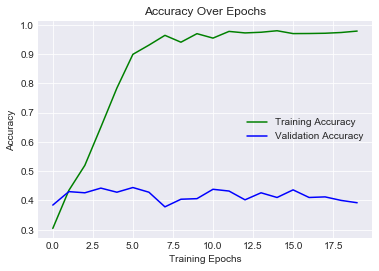

In [60]:
plt.plot(hist.history["accuracy"], label="Training Accuracy", color="green")
plt.plot(hist.history["val_accuracy"], label="Validation Accuracy", color="blue")
plt.title("Accuracy Over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


In [61]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Accuracy: {acc}, Loss: {loss}')

500/1 - 1s - loss: 7.5927 - accuracy: 0.3760
Accuracy: 0.37599998712539673, Loss: 6.167707855224609


It is clear from this more complicated model that we are overfitting. We receive a constant training accuracy of about 97% at epoch 12 and it never goes below that. We aren't really learning anything new. In the original Conv4, we did not recieve this bad of an overfit. Our overall test accuracy takes a major hit here because of the overfitting. This calls for a dropout layer in this more complicated model.

In [63]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(input_shape=stl_imgs.shape[1:],filters=32, kernel_size=(7,7),padding="same", activation='relu',),
    tf.keras.layers.Conv2D(input_shape=stl_imgs.shape[1:],filters=32, kernel_size=(5,5),padding="same", activation='relu',),
    tf.keras.layers.Conv2D(input_shape=stl_imgs.shape[1:],filters=64, kernel_size=(3,3),padding="same", activation='relu',),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid', data_format="channels_last" ),
    tf.keras.layers.Flatten(input_shape=(16,16,64)),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dropout(.7),
    tf.keras.layers.Dense(units=10, activation="softmax") 
]) 
model.summary()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy']) 
hist = model.fit(x_train, y_train, batch_size=4, epochs=20, validation_data=(x_val, y_val), verbose=2)

W1120 00:06:29.070163 140734928358848 nn_ops.py:4283] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1120 00:06:29.252650 140734928358848 nn_ops.py:4283] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        4736      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        25632     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 100)               1638500   
_________________________________________________________________
dropout (Dropout)            (None, 100)             

W1120 00:06:29.448613 140734928358848 nn_ops.py:4283] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


3500/3500 - 30s - loss: 2.2302 - accuracy: 0.1486 - val_loss: 2.0604 - val_accuracy: 0.2360
Epoch 2/20
3500/3500 - 32s - loss: 2.0240 - accuracy: 0.2237 - val_loss: 1.9407 - val_accuracy: 0.2640
Epoch 3/20
3500/3500 - 31s - loss: 1.9205 - accuracy: 0.2397 - val_loss: 1.7853 - val_accuracy: 0.3040
Epoch 4/20
3500/3500 - 31s - loss: 1.8398 - accuracy: 0.2660 - val_loss: 1.7876 - val_accuracy: 0.3060
Epoch 5/20
3500/3500 - 30s - loss: 1.8131 - accuracy: 0.2820 - val_loss: 1.7317 - val_accuracy: 0.3320
Epoch 6/20
3500/3500 - 29s - loss: 1.7706 - accuracy: 0.2909 - val_loss: 1.6632 - val_accuracy: 0.3600
Epoch 7/20
3500/3500 - 31s - loss: 1.7180 - accuracy: 0.3214 - val_loss: 1.6085 - val_accuracy: 0.3980
Epoch 8/20
3500/3500 - 31s - loss: 1.6665 - accuracy: 0.3477 - val_loss: 1.5944 - val_accuracy: 0.3820
Epoch 9/20
3500/3500 - 30s - loss: 1.6113 - accuracy: 0.3637 - val_loss: 1.5629 - val_accuracy: 0.4280
Epoch 10/20
3500/3500 - 29s - loss: 1.5638 - accuracy: 0.3794 - val_loss: 1.5663 - v

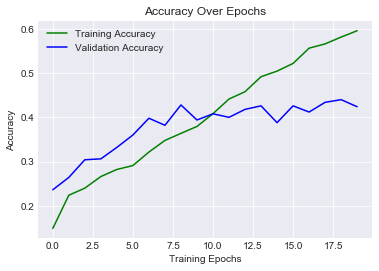

In [64]:
plt.plot(hist.history["accuracy"], label="Training Accuracy", color="green")
plt.plot(hist.history["val_accuracy"], label="Validation Accuracy", color="blue")
plt.title("Accuracy Over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


In [65]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Accuracy: {acc}, Loss: {loss}')

500/1 - 1s - loss: 1.8439 - accuracy: 0.4120
Accuracy: 0.41200000047683716, Loss: 1.846271499633789


Adding a dropout layer seems to have helped with the overfitting. It is clear that the training accuracy did not hit the maximum it could have, only achieving 60% rather than the 97% of before. This is because I was likely overzealous with my dropout rate. Additionally, batch size is something to mess with as well. Considering rumors of a batch size of 32 being a good number, I will try that next with a lower dropout rate.

In [66]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(input_shape=stl_imgs.shape[1:],filters=32, kernel_size=(7,7),padding="same", activation='relu',),
    tf.keras.layers.Conv2D(input_shape=stl_imgs.shape[1:],filters=32, kernel_size=(5,5),padding="same", activation='relu',),
    tf.keras.layers.Conv2D(input_shape=stl_imgs.shape[1:],filters=64, kernel_size=(3,3),padding="same", activation='relu',),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid', data_format="channels_last" ),
    tf.keras.layers.Flatten(input_shape=(16,16,64)),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(units=10, activation="softmax") 
]) 
model.summary()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy']) 
hist = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val), verbose=2)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        4736      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        25632     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               1638500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)             

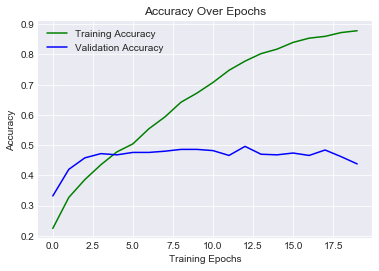

In [67]:
plt.plot(hist.history["accuracy"], label="Training Accuracy", color="green")
plt.plot(hist.history["val_accuracy"], label="Validation Accuracy", color="blue")
plt.title("Accuracy Over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


In [68]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Accuracy: {acc}, Loss: {loss}')

500/1 - 0s - loss: 3.3519 - accuracy: 0.4720
Accuracy: 0.47200000286102295, Loss: 2.5658507766723635


The decrease in batch size made a large difference, both in training time and the amount of time it took to increase our accuracy. In fact, we hit a much higher accuracy than before and did not overfit until the end. The dropoff in validation accuracy was somewhat dissapointing but worse dropoff in validation may have been prevented by the dropout layer. Out of curiousity, I am going to change my batch size on the original Conv4 below and see what sort of accuracy we can achieve.

In [69]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(input_shape=stl_imgs.shape[1:],filters=32, kernel_size=(7,7),padding="same", activation='relu',),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid', data_format="channels_last" ),
    tf.keras.layers.Flatten(input_shape=(16,16,32)),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=10, activation="softmax") 
]) 
model.summary()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy']) 
hist = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val), verbose=2)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 32)        4736      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 100)               819300    
_________________________________________________________________
dense_28 (Dense)             (None, 10)                1010      
Total params: 825,046
Trainable params: 825,046
Non-trainable params: 0
_________________________________________________________________
Train on 3500 samples, validate on 500 samples
Epoch 1/20
3500/3500 - 4s - loss: 1.8260 - accuracy: 0.3294 - val_

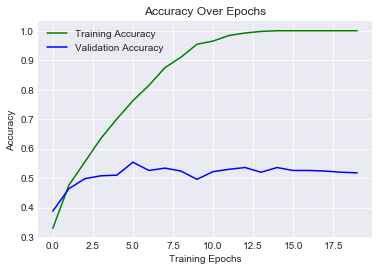

In [70]:
plt.plot(hist.history["accuracy"], label="Training Accuracy", color="green")
plt.plot(hist.history["val_accuracy"], label="Validation Accuracy", color="blue")
plt.title("Accuracy Over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


In [71]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Accuracy: {acc}, Loss: {loss}')

500/1 - 0s - loss: 3.6136 - accuracy: 0.5520
Accuracy: 0.5519999861717224, Loss: 2.413445297241211


Considering the drastic increase in accuracy, it seems we have a difference here in batch size rather than model complexity. This model, with half the weights of the other models, trains in 1/6th of the time and is more accurate by a significant amount. It looks like there is still some overfitting to battle, so I will add a dropout layer to it to see if there is a difference.

In [72]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(input_shape=stl_imgs.shape[1:],filters=32, kernel_size=(7,7),padding="same", activation='relu',),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid', data_format="channels_last" ),
    tf.keras.layers.Flatten(input_shape=(16,16,32)),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dropout(.35),
    tf.keras.layers.Dense(units=10, activation="softmax") 
]) 
model.summary()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy']) 
hist = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val), verbose=2)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 32)        4736      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 100)               819300    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)                1010      
Total params: 825,046
Trainable params: 825,046
Non-trainable params: 0
_______________________________________________

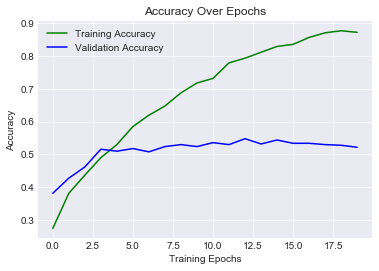

In [73]:
plt.plot(hist.history["accuracy"], label="Training Accuracy", color="green")
plt.plot(hist.history["val_accuracy"], label="Validation Accuracy", color="blue")
plt.title("Accuracy Over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [74]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Accuracy: {acc}, Loss: {loss}')

500/1 - 0s - loss: 2.3407 - accuracy: 0.5140
Accuracy: 0.5139999985694885, Loss: 1.6189593925476073


It appears that dropout was not useful in the long term here. We lost accuracy by nearly 4%. We look like we peaked at about 11 epochs, so maybe there is something to learn at 11 epochs that we lose with later epochs.

In [75]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(input_shape=stl_imgs.shape[1:],filters=32, kernel_size=(7,7),padding="same", activation='relu',),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid', data_format="channels_last" ),
    tf.keras.layers.Flatten(input_shape=(16,16,32)),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dropout(.35),
    tf.keras.layers.Dense(units=10, activation="softmax") 
]) 
model.summary()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy']) 
hist = model.fit(x_train, y_train, batch_size=32, epochs=11, validation_data=(x_val, y_val), verbose=2)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 32)        4736      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 100)               819300    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 10)                1010      
Total params: 825,046
Trainable params: 825,046
Non-trainable params: 0
_______________________________________________

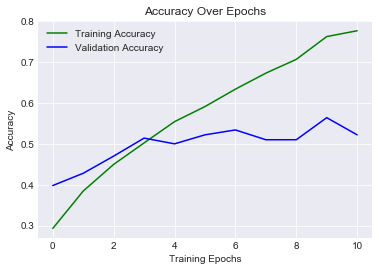

In [76]:
plt.plot(hist.history["accuracy"], label="Training Accuracy", color="green")
plt.plot(hist.history["val_accuracy"], label="Validation Accuracy", color="blue")
plt.title("Accuracy Over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [77]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Accuracy: {acc}, Loss: {loss}')

500/1 - 0s - loss: 1.8477 - accuracy: 0.5200
Accuracy: 0.5199999809265137, Loss: 1.450166109085083


It actually appears that we increase accuracy by 1%, but do not achieve what we had without dropout. This forces us to ponder whether decreasing the length of time the original Conv4 algorithm trains is worth something. Let us explore that.

In [78]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(input_shape=stl_imgs.shape[1:],filters=32, kernel_size=(7,7),padding="same", activation='relu',),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid', data_format="channels_last" ),
    tf.keras.layers.Flatten(input_shape=(16,16,32)),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=10, activation="softmax") 
]) 
model.summary()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy']) 
hist = model.fit(x_train, y_train, batch_size=32, epochs=11, validation_data=(x_val, y_val), verbose=2)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        4736      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 100)               819300    
_________________________________________________________________
dense_34 (Dense)             (None, 10)                1010      
Total params: 825,046
Trainable params: 825,046
Non-trainable params: 0
_________________________________________________________________
Train on 3500 samples, validate on 500 samples
Epoch 1/11
3500/3500 - 4s - loss: 1.8093 - accuracy: 0.3320 - val_

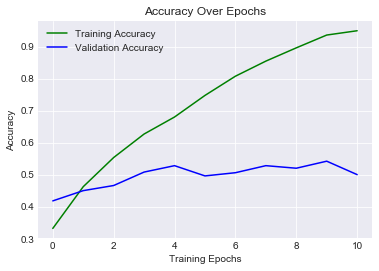

In [79]:
plt.plot(hist.history["accuracy"], label="Training Accuracy", color="green")
plt.plot(hist.history["val_accuracy"], label="Validation Accuracy", color="blue")
plt.title("Accuracy Over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [80]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Accuracy: {acc}, Loss: {loss}')

500/1 - 0s - loss: 2.6177 - accuracy: 0.5180
Accuracy: 0.5180000066757202, Loss: 1.8679421348571776


It seems that we do not achieve the accuracy we may have been looking for and that this is on par with that of the dropout model, proven to be worse. However, we did not peak in our training accuracy, so we will train for a bit longer.

In [81]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(input_shape=stl_imgs.shape[1:],filters=32, kernel_size=(7,7),padding="same", activation='relu',),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid', data_format="channels_last" ),
    tf.keras.layers.Flatten(input_shape=(16,16,32)),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=10, activation="softmax") 
]) 
model.summary()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy']) 
hist = model.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_val, y_val), verbose=2)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 32)        4736      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 100)               819300    
_________________________________________________________________
dense_36 (Dense)             (None, 10)                1010      
Total params: 825,046
Trainable params: 825,046
Non-trainable params: 0
_________________________________________________________________
Train on 3500 samples, validate on 500 samples
Epoch 1/15
3500/3500 - 4s - loss: 1.8262 - accuracy: 0.3346 - val_

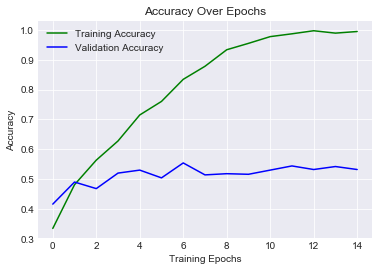

In [82]:
plt.plot(hist.history["accuracy"], label="Training Accuracy", color="green")
plt.plot(hist.history["val_accuracy"], label="Validation Accuracy", color="blue")
plt.title("Accuracy Over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [83]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Accuracy: {acc}, Loss: {loss}')

500/1 - 0s - loss: 3.4668 - accuracy: 0.5280
Accuracy: 0.527999997138977, Loss: 2.3529868621826173


Success! We have increased our accuracy, and approached what seems to be the bounds of overfitting. We will try a bit more than 20 epochs to see if we can increase our accuracy by training for longer because our 20 is the best so far.

In [84]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(input_shape=stl_imgs.shape[1:],filters=32, kernel_size=(7,7),padding="same", activation='relu',),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid', data_format="channels_last" ),
    tf.keras.layers.Flatten(input_shape=(16,16,32)),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=10, activation="softmax") 
]) 
model.summary()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy']) 
hist = model.fit(x_train, y_train, batch_size=32, epochs=25, validation_data=(x_val, y_val), verbose=2)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 32)        4736      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 100)               819300    
_________________________________________________________________
dense_38 (Dense)             (None, 10)                1010      
Total params: 825,046
Trainable params: 825,046
Non-trainable params: 0
_________________________________________________________________
Train on 3500 samples, validate on 500 samples
Epoch 1/25
3500/3500 - 4s - loss: 1.7966 - accuracy: 0.3217 - val_

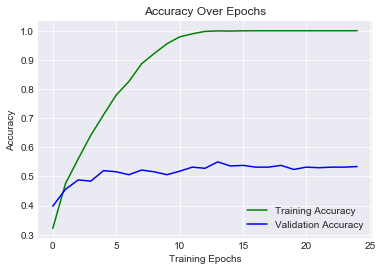

In [85]:
plt.plot(hist.history["accuracy"], label="Training Accuracy", color="green")
plt.plot(hist.history["val_accuracy"], label="Validation Accuracy", color="blue")
plt.title("Accuracy Over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [87]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Accuracy: {acc}, Loss: {loss}')

500/1 - 0s - loss: 3.9977 - accuracy: 0.5140
Accuracy: 0.5139999985694885, Loss: 2.873208042144775


It looks like our best success is about 20 epochs with a batch size of 32 on standard Conv4. This is interesting because we battle overfitting in our model when training for longer. It seems batch size has more importance than we first anticipated, and it would be interesting to extend messing around with batch size. One more thing that is interesting is using the MobileNet model to try to fit this work.

In [110]:
#forcing it to load a 96x96x3 instead of 32x32x3
load_stl10_dataset.purge_cached_dataset()

stl_imgs, stl_labels = load_stl10_dataset.load()
classes = np.loadtxt(os.path.join('data', 'stl10_binary', 'class_names.txt'), dtype=str)
stl_imgs, stl_labels = preprocess_stl(stl_imgs, stl_labels)
x_train, y_train, x_test, y_test, x_val, y_val, x_dev, y_dev = create_splits(stl_imgs, stl_labels)  

model = tf.keras.applications.MobileNetV2(input_shape=(96,96,3),include_top=False,
                                               weights='imagenet')
model.trainable=False
mn_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=10, activation='softmax')
])
mn_model.summary()
mn_model.compile(optimizer='adam', learning_rate=.001,
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
hist = mn_model.fit(x_train, y_train, 
                    validation_data=(x_val,y_val),
                     epochs=10,
                     verbose=2,
                     batch_size=32)


Images are: (5000, 96, 96, 3)
Labels are: (5000,)
Saving Numpy arrays the images and labels to ./numpy...Done!
imgs.shape (5000, 96, 96, 3)
data.shape (5000, 96, 96, 3)
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
flatten_44 (Flatten)         (None, 11520)             0         
_________________________________________________________________
dense_57 (Dense)             (None, 10)                115210    
Total params: 2,373,194
Trainable params: 115,210
Non-trainable params: 2,257,984
_________________________________________________________________
Train on 3500 samples, validate on 500 samples
Epoch 1/10
3500/3500 - 38s - loss: 0.7730 - accuracy: 0.8089 - val_loss: 0.9365 - val_accuracy: 0.8400
Epoch 2/10
3500/3500 - 29s - loss: 0.2492 - accu

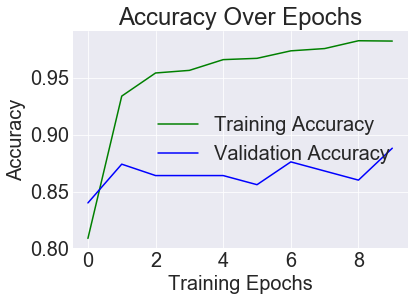

In [111]:
plt.plot(hist.history["accuracy"], label="Training Accuracy", color="green")
plt.plot(hist.history["val_accuracy"], label="Validation Accuracy", color="blue")
plt.title("Accuracy Over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [112]:
loss, acc = mn_model.evaluate(x_test, y_test, verbose=2)
print(f'Accuracy: {acc}, Loss: {loss}')

500/1 - 2s - loss: 1.0169 - accuracy: 0.9020
Accuracy: 0.9020000100135803, Loss: 0.7970676336288453


In this section, to make it fit to mobile net, we had to resize the images back out to 96x96x3. This is likely the largest point of improvement because we now have more information to learn. Our other models were learning all there was to learn. This model had more total to learn with the larger images, therefore making it easier for it to make classifications. However, seeing a 90% accuracy with these larger images and MobileNet is cool because it proves there is something capable for classification. Furthermore, it puts in perspective how much is possible to learn with just 32x32 images. It is really incredible that we achieved 55% accuracy on the Conv4 with that size image. Overfitting was difficult, but simply because of the image size. Increase the image size and there is so much more capability in these models. It seems we could train even further on this, more than 10 epochs. 15 might do a better, seen below.

In [114]:
model = tf.keras.applications.MobileNetV2(input_shape=(96,96,3),include_top=False,
                                               weights='imagenet')
model.trainable=False
mn_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=10, activation='softmax')
])
mn_model.summary()
mn_model.compile(optimizer='adam', learning_rate=.001,
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
hist = mn_model.fit(x_train, y_train, 
                    validation_data=(x_val,y_val),
                     epochs=15,
                     verbose=2,
                     batch_size=32)

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
flatten_46 (Flatten)         (None, 11520)             0         
_________________________________________________________________
dense_59 (Dense)             (None, 10)                115210    
Total params: 2,373,194
Trainable params: 115,210
Non-trainable params: 2,257,984
_________________________________________________________________
Train on 3500 samples, validate on 500 samples
Epoch 1/15
3500/3500 - 32s - loss: 0.7686 - accuracy: 0.8086 - val_loss: 0.9476 - val_accuracy: 0.8580
Epoch 2/15
3500/3500 - 31s - loss: 0.2693 - accuracy: 0.9249 - val_loss: 0.8069 - val_accuracy: 0.8720
Epoch 3/15
3500/3500 - 27s - loss: 0.1898 - accuracy: 0.9466 - val_loss: 1.0021 - val_accuracy: 0.8600
Epoch 4/15


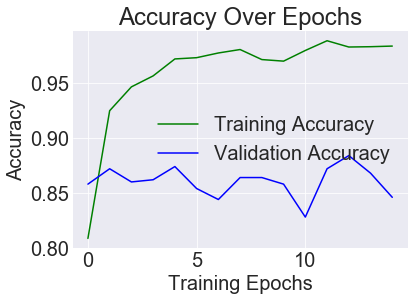

In [115]:
plt.plot(hist.history["accuracy"], label="Training Accuracy", color="green")
plt.plot(hist.history["val_accuracy"], label="Validation Accuracy", color="blue")
plt.title("Accuracy Over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [116]:
loss, acc = mn_model.evaluate(x_test, y_test, verbose=2)
print(f'Accuracy: {acc}, Loss: {loss}')

500/1 - 2s - loss: 1.6004 - accuracy: 0.8700
Accuracy: 0.8700000047683716, Loss: 1.32589005279541


It looks like we overfit. Somewhere between 10 and 15 epochs is some happy medium in which the model excels. It is interesting how drastically overfitting causes problems within the model, and we can see that throughout.